# Regression Project: Estimating Home Value

### Project Goals:

* Predict the values of single unit properties using the property data from those with a transaction during the "hot months" of May-August 2017 based on the tax assessed value

* Find where the properties are located 

* Calculate and visualize the distribution of tax rates for each county

### Data Science Pipeline:
1. Plan 
2. Acquire Data
3. Prepare Data
4. Data Exploration
5. Modeling and Evaluation

### Initial Hypotheses
- Is there in tax value between different counties?
- Is there a correlation between square footage of a home and tax value?


In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import env
import warnings
warnings.filterwarnings("ignore")

#Files to acquire and prep data
import wrangle 

#Split and scale 
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split
from wrangle import Min_Max_Scaler

#Evaluation/Modeling Methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

## Data Acquisition 

In [2]:
#Using cached_zillow to acquire data from MySQL 
df = wrangle.cached_zillow(cached = True)
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38622 entries, 0 to 38621
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      38622 non-null  int64  
 1   id                            38622 non-null  int64  
 2   airconditioningtypeid         12224 non-null  float64
 3   architecturalstyletypeid      101 non-null    float64
 4   basementsqft                  27 non-null     float64
 5   bathroomcnt                   38622 non-null  float64
 6   bedroomcnt                    38622 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         23706 non-null  float64
 9   calculatedbathnbr             38463 non-null  float64
 10  decktypeid                    333 non-null    float64
 11  finishedfloor1squarefeet      3339 non-null   float64
 12  calculatedfinishedsquarefeet  38509 non-null  float64
 13  f

In [4]:
#Check for null values 
df.isna().sum()

parcelid                        0
id                              0
airconditioningtypeid       26398
architecturalstyletypeid    38521
basementsqft                38595
                            ...  
taxdelinquencyyear          37354
censustractandblock           144
id.1                            0
logerror                        0
transactiondate                 0
Length: 62, dtype: int64

In [5]:
#Number of rows and columns 
df.shape

(38622, 62)

Text(0.5, 1.0, 'Distribution of Square Feet')

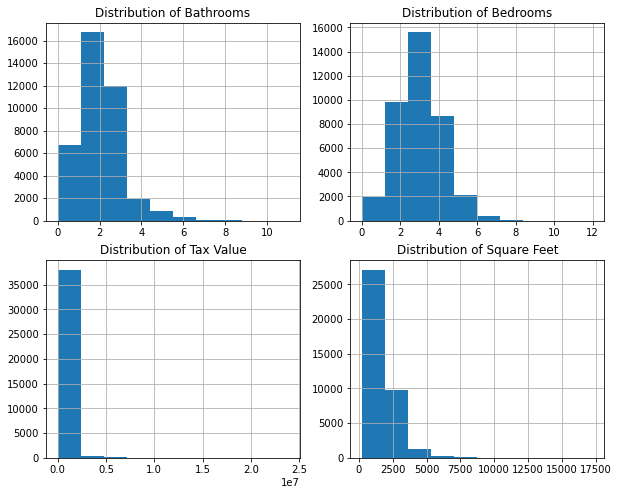

In [6]:
#Subplots to show distribution of numeric columns 
plt.figure(figsize=(10, 8))

plt.subplot(221)
df.bathroomcnt.hist()
plt.gca().set_title('Distribution of Bathrooms')

plt.subplot(222)
df.bedroomcnt.hist()
plt.gca().set_title('Distribution of Bedrooms')

plt.subplot(223)
df.taxvaluedollarcnt.hist() 
plt.gca().set_title('Distribution of Tax Value')

plt.subplot(224)
df.calculatedfinishedsquarefeet.hist()
plt.gca().set_title('Distribution of Square Feet')

## Data Preparation

Functions to prepare, split, and scale data are in `wrangle.py` file
-  `clean_zillow` `function` will take one argument df, a pandas dataframe and will:
    - grab the features needed for estimating home value,
    - set parcelid as new index,
    - rename columns for readability,
    - calculate age of home,
    - drop null values,
    - convert data types to integers, 
    - remove outliers from square_feet and tax_value, 
    - and calculate tax rate
    - return: a single pandas dataframe with the above operations performed
- `split` `function` takes in a dataframe and returns train, validate, and test dataframe

- `min_max_scaler` `function` takes in X_train, X_validate and X_test dfs with numeric values only and makes, fits, and uses/transforms the data then returns X_train_scaled, X_validate_scaled, X_test_scaled dataframes 

In [7]:
zillow_df = wrangle.clean_zillow(df)

In [8]:
zillow_df.head()

,bedrooms,bathrooms,square_feet,fips,county,age,tax_value,taxes,tax_rate
parcelid,,,,,,,,,
14634203,3,2.0,1125,6059,1286,43,289445,3490.16,1.205811
11721753,3,2.0,1316,6037,3101,94,205123,2627.48,1.280929
11289917,3,2.0,1458,6037,3101,47,136104,2319.90,1.704505
11637029,3,2.0,1766,6037,3101,37,810694,9407.01,1.160365
11705026,2,1.0,1421,6037,3101,106,35606,543.69,1.526962


In [9]:
#Check for null values 
zillow_df.isnull().sum()

bedrooms       0
bathrooms      0
square_feet    0
fips           0
county         0
age            0
tax_value      0
taxes          0
tax_rate       0
dtype: int64

In [10]:
#Check datatypes
zillow_df.dtypes

bedrooms         int64
bathrooms      float64
square_feet      int64
fips             int64
county           int64
age              int64
tax_value        int64
taxes          float64
tax_rate       float64
dtype: object

In [11]:
df = zillow_df.drop(columns=['taxes', 'tax_rate'])

In [12]:
#Split into train, validate, test 
train, validate, test = wrangle.split(df)

In [13]:
#check split datasets
print('overall shape of dataframe:', df.shape)
print('train:', train.shape)
print('validate:', validate.shape)
print('test:', test.shape)

#work w/ training data for data exploration
train.head()

overall shape of dataframe: (34837, 7)
train: (19508, 7)
validate: (8361, 7)
test: (6968, 7)


,bedrooms,bathrooms,square_feet,fips,county,age,tax_value
parcelid,,,,,,,
10712731,3,2.0,1962,6037,3101,54,86942
17139143,2,2.0,1070,6111,2061,39,78600
12488599,2,1.0,1132,6037,3101,75,228724
14308150,2,2.0,1208,6059,1286,37,698413
14444150,3,2.0,1855,6059,1286,52,301297


In [14]:
#set up X inputs and y target variable for each split
X_train = train.drop(columns=['tax_value'])
y_train = train.tax_value
X_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value
X_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

In [15]:
#test scaling function from wrangle.py
X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)
X_train_scaled.head()

,bedrooms,bathrooms,square_feet,fips,county,age
parcelid,,,,,,
10712731,0.333333,0.266667,0.537957,0.000000,1.000000,0.404580
17139143,0.222222,0.266667,0.259294,1.000000,0.426997,0.290076
12488599,0.222222,0.133333,0.278663,0.000000,1.000000,0.564885
14308150,0.222222,0.266667,0.302405,0.297297,0.000000,0.274809
14444150,0.333333,0.266667,0.504530,0.297297,0.000000,0.389313


## Data Exploration

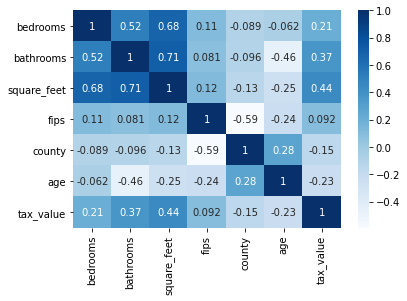

In [16]:
#exploring correlation using heatmap
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.show()

Findings/Takeaways:
- Tax value has some correlation with square footable 
- Bathrooms has a stronger correlation with tax value than bedrooms

### Continuous and Categorical

In [17]:
def plot_categorical_and_continuous_vars(df, categorical_var, continuous_var):
    '''
    This function will accept my dataframe 
    and the names of the cols that hold the categorical and continuous features,
    and output 3 different plots for visualizing a categorical var and a continuous var
    '''
    sns.barplot(data=df, y=continuous_var, x=categorical_var)
    plt.show()
    sns.scatterplot(data=df, y=continuous_var, x=categorical_var)
    plt.show()
    sns.boxplot(data=df, y=continuous_var, x=categorical_var)

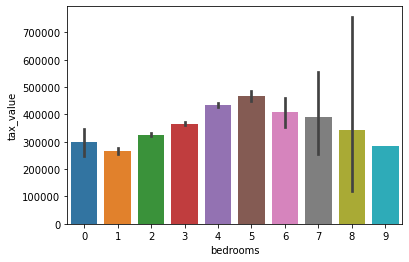

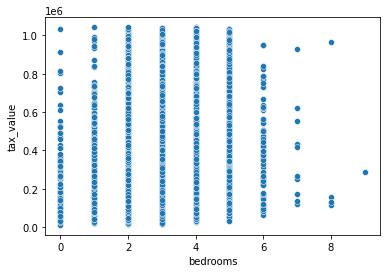

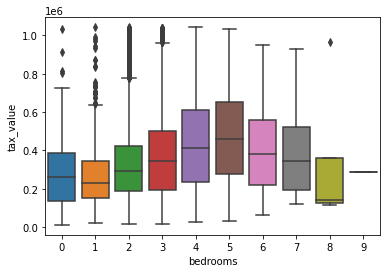

In [18]:
plot_categorical_and_continuous_vars(train, 'bedrooms', 'tax_value')

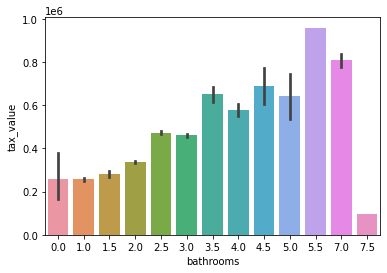

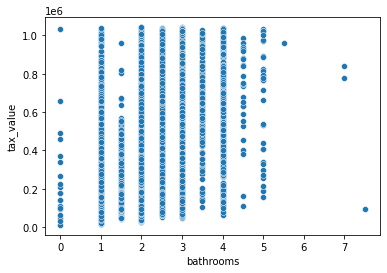

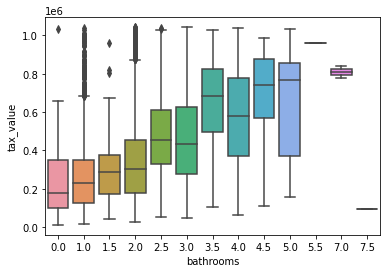

In [19]:
plot_categorical_and_continuous_vars(train, 'bathrooms', 'tax_value')

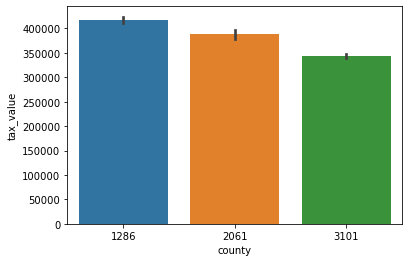

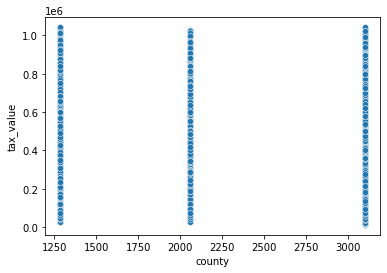

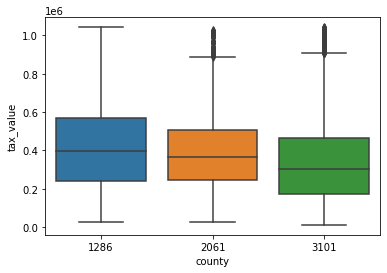

In [20]:
plot_categorical_and_continuous_vars(train, 'county', 'tax_value')

In [21]:
#create a df to show the name of the county for each fips code
county = pd.DataFrame({'county_fips_code': [6037, 6059, 6111],
                       'County': ['Los Angeles', 'Orange', 'Ventura']})
county.head()

,county_fips_code,County
0,6037,Los Angeles
1,6059,Orange
2,6111,Ventura


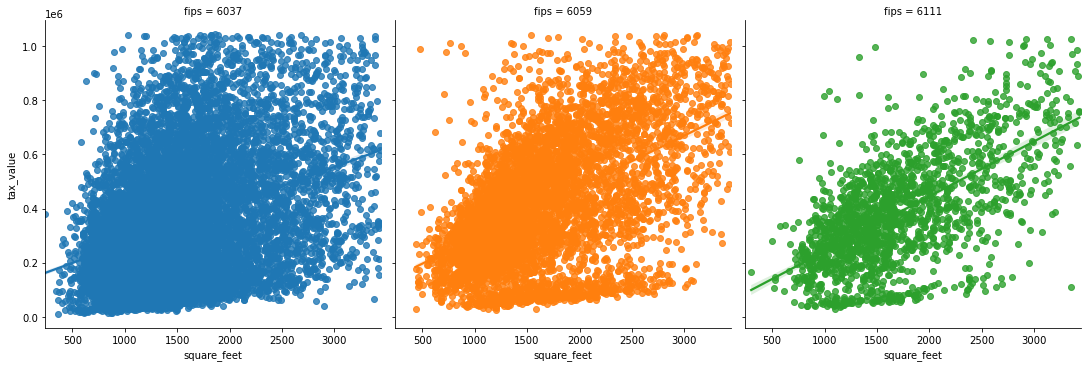

In [22]:
#Visualize how square footage influences the property's assessed value by county
sns.lmplot(data=train, 
           x='square_feet', 
           y='tax_value', 
           hue = 'fips', 
           col = 'fips', 
           col_wrap=3)

plt.show()

### Findings/Takeaways:

There is an upward trend between square footage and a property's assessed value for all counties.
The more square feet in a property, the higher the tax value.

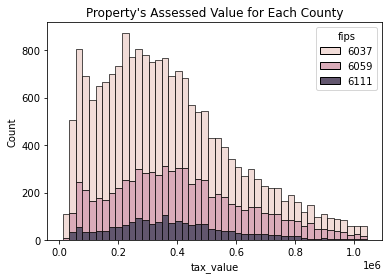

In [23]:
#Visualize the property's assessed value for each of the counties
sns.histplot(data=train, x="tax_value", hue="fips", multiple="stack")
plt.title("Property's Assessed Value for Each County")
plt.show()

## Hypothesis Testing


### Correlation Test

$H_0$ = There is no relationship between total square footage and tax value

$H_a$ = There is a relationship between total square footage and tax value

In [24]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_interval = 0.95
a = 1 - confidence_interval 

#Use personr function
corr, p = stats.pearsonr(train.square_feet, train.tax_value)

print(f"Pearson's correlation coefficient: {corr} and p-value is: {p}")

if p < a:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

Pearson's correlation coefficient: 0.4428027976416838 and p-value is: 0.0
We reject the null hypothesis.


## T-Test

$H_0$ = There is no difference in tax value between Los Angeles and the rest of the counties.

$H_a$ = There is a difference in tax value.

In [25]:
null_hypothesis = "there is no difference in tax value between Los Angeles county and the rest of the counties"
alternative_hypothesis = "there is a difference in tax value"
confidence_level = .95
alpha = 1 - confidence_level
la_county = train[train.fips  == 6037].tax_value
other_counties = train[train.fips != 6037].tax_value
t, p = stats.ttest_ind(la_county, other_counties)
print(t, p)
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

-20.680342404375658 5.305697388957119e-94
We reject the null hypothesis that there is no difference in tax value between Los Angeles county and the rest of the counties


### Key Findings/Takeaways:
T-test and correlation hypothesis tests rejected the null hypothesis and can move forward with the alternative hypothesis:
There is a correlation between tax value and square footage of a home.
There is a difference in tax value between Los Angeles county and the other counties.

## KBest Features 

In [29]:
from sklearn.feature_selection import SelectKBest, f_regression

In [30]:
f_selector = SelectKBest(f_regression, k=5)

In [31]:
## we are running the scaled train data through kbest
f_selector = f_selector.fit(X_train_scaled, y_train)

In [32]:
## Transforming the data
X_train_reduced = f_selector.transform(X_train_scaled)
print(X_train.shape)
print(X_train_reduced.shape)

(19508, 6)
(19508, 5)


In [33]:
f_support = f_selector.get_support()
f_support

array([ True,  True,  True, False,  True,  True])

In [34]:
## Listing out the features so we can see which ones were returned
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
f_feature

['bedrooms', 'bathrooms', 'square_feet', 'county', 'age']

In [35]:
# Returning a scaled dataframe with only our best features
X_reduced_scaled = X_train_scaled.iloc[:, f_support]
X_reduced_scaled.head()

,bedrooms,bathrooms,square_feet,county,age
parcelid,,,,,
10712731,0.333333,0.266667,0.537957,1.000000,0.404580
17139143,0.222222,0.266667,0.259294,0.426997,0.290076
12488599,0.222222,0.133333,0.278663,1.000000,0.564885
14308150,0.222222,0.266667,0.302405,0.000000,0.274809
14444150,0.333333,0.266667,0.504530,0.000000,0.389313


### Key Findings 
bedrooms, bathrooms, square_feet, county, age are likely best features to use 

## Data Modeling and Evaluation

In [36]:
#defining functions to get evaluation metrics for models
def residuals(actual, predicted):
    return actual - predicted

def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def evaluation_metrics_mean(actual):
    predicted = actual.mean()
    return {'sse': sse(actual, predicted), 
            'mse': mse(actual, predicted), 
            'rmse': rmse(actual, predicted)}

def evaluation_metrics_median(actual):
    predicted = actual.median()
    return {'sse': sse(actual, predicted), 
            'mse': mse(actual, predicted), 
            'rmse': rmse(actual, predicted)}

### Establish/Evaluate a Baseline Model

In [37]:
#Convert y_train and y_validate to dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Predict tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#Compute tax_value_pred_median
tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median


In [38]:
import math

In [39]:
#Evaluate the baseline model using the mean
evaluation_metrics_mean(y_train.tax_value)

{'sse': 983333176058051.1,
 'mse': 50406662705.456795,
 'rmse': 224514.28174050932}

In [40]:
#Evaluate the baseline model using the median
evaluation_metrics_median(y_train.tax_value)

{'sse': 1005616490831297.0,
 'mse': 51548928174.66152,
 'rmse': 227043.89041474232}

### Findings:

Using mean for baseline

In [41]:
#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  224514.28 
Validate/Out-of-Sample:  226126.54


In [42]:
#incrementally building a df for comparison of metrics for model selection
metric_df = pd.DataFrame(data = [{'model': 'mean_baseline', 
                                  'RMSE_validate': rmse_validate,
                                  'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_mean)}])

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,226126.536116,0.0


## Linear Regression (OLS)

In [43]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.tax_value)


# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)


# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  196834.97168533588 
Validation/Out-of-Sample:  195982.47785395538


In [44]:
metric_df = metric_df.append({'model': 'OLS Regressor', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,226126.536116,0.000000
1,OLS Regressor,195982.477854,0.248837


## LassoLars 

In [45]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  196834.97168533588 
Validation/Out-of-Sample:  195982.47785395538


In [46]:
metric_df = metric_df.append({'model': 'Lasso alpha 1', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lars)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,226126.536116,0.000000
1,OLS Regressor,195982.477854,0.248837
2,Lasso alpha 1,195982.477854,0.248813


## TweedieRegressor (GLM)

In [47]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  197049.85786882832 
Validation/Out-of-Sample:  197049.85786882832


In [48]:
metric_df = metric_df.append({'model': 'GLM (Poisson)', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_glm)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,226126.536116,0.000000
1,OLS Regressor,195982.477854,0.248837
2,Lasso alpha 1,195982.477854,0.248813
3,GLM (Poisson),197049.857869,0.247598


## Polynomial Regression

In [49]:
## Polynomial Features ##
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)


## LinearRegression ##
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  196834.97168533588 
Validation/Out-of-Sample:  38409131625.77611


In [50]:
metric_df = metric_df.append({'model': 'Quadratic Model', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm2)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,2.261265e+05,0.000000
1,OLS Regressor,1.959825e+05,0.248837
2,Lasso alpha 1,1.959825e+05,0.248813
3,GLM (Poisson),1.970499e+05,0.247598
4,Quadratic Model,3.840913e+10,0.248837


## Evaluate
- OLS Regressor and Lasso alpha 1 had similar scores, but will be moving forward with just the OLS Regressor.
- GLM (Poisson) also had a decent score
- Models to visualize are OLS Regressor and GLM (Poisson)

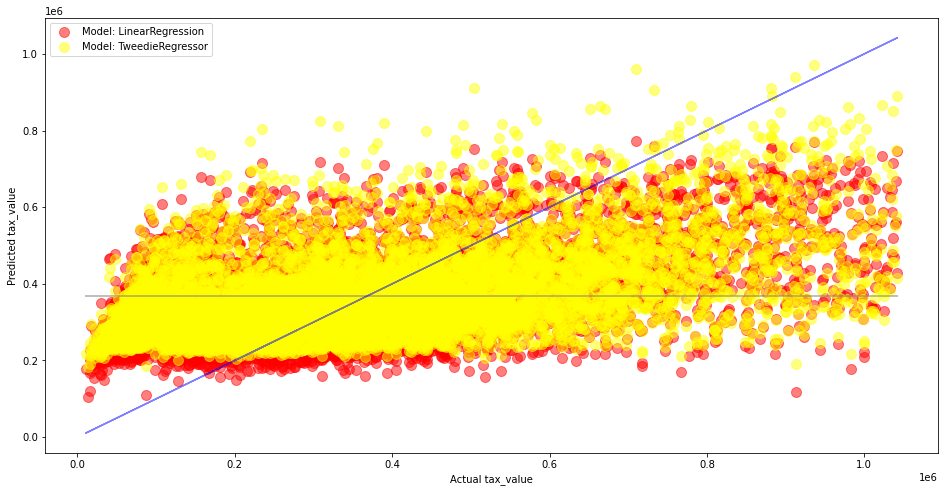

In [51]:
#Plotting Actual vs Predicted Values
# y_validate.head()
plt.figure(figsize=(16,8))

plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')

plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")

plt.legend()
plt.xlabel("Actual tax_value")
plt.ylabel("Predicted tax_value")
plt.show()

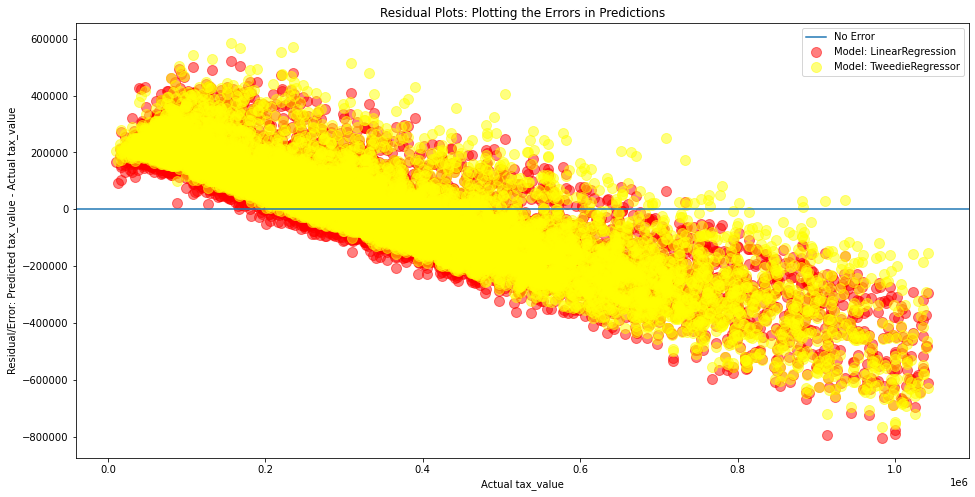

In [52]:
#Residual Plots: Plotting the Errors in Predictions
# y_validate.head()
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm - y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")

plt.legend()
plt.xlabel("Actual tax_value")
plt.ylabel("Residual/Error: Predicted tax_value - Actual tax_value")
plt.title("Residual Plots: Plotting the Errors in Predictions")
plt.show()

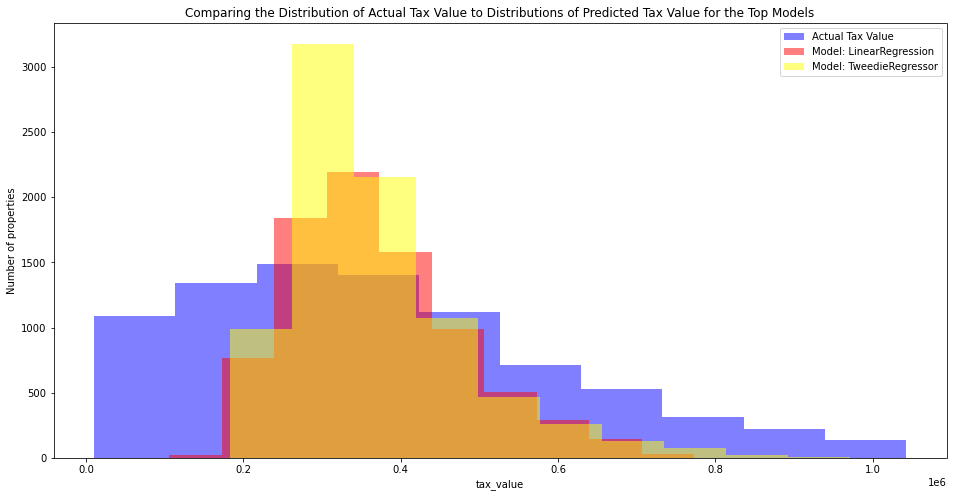

<Figure size 432x288 with 0 Axes>

In [64]:
#histogram
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")

plt.xlabel("tax_value")
plt.ylabel("Number of properties")
plt.title("Comparing the Distribution of Actual Tax Value to Distributions of Predicted Tax Value for the Top Models")
plt.legend()
plt.show()
plt.savefig('models.png')


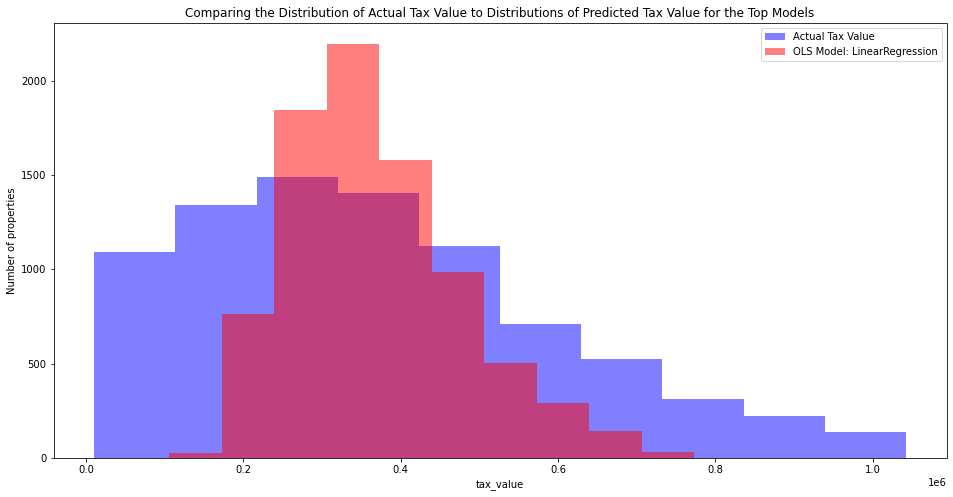

<Figure size 432x288 with 0 Axes>

In [67]:
#histogram
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="OLS Model: LinearRegression")

plt.xlabel("tax_value")
plt.ylabel("Number of properties")
plt.title("Comparing the Distribution of Actual Tax Value to Distributions of Predicted Tax Value for the Top Models")
plt.legend()
plt.show()
plt.savefig('OLSmodels.png')

In [54]:
#out of sample evaluation
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_value_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse and r^2
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm) ** (1/2)
r2_test = explained_variance_score(y_test.tax_value, y_test.tax_value_pred_lm)
print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)
print('r^2_validate:', r2_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  196365.27390679737
r^2_validate: 0.23424814928662663


## Distribution of Tax Rates

In [55]:
zillow_df.head()

,bedrooms,bathrooms,square_feet,fips,county,age,tax_value,taxes,tax_rate
parcelid,,,,,,,,,
14634203,3,2.0,1125,6059,1286,43,289445,3490.16,1.205811
11721753,3,2.0,1316,6037,3101,94,205123,2627.48,1.280929
11289917,3,2.0,1458,6037,3101,47,136104,2319.90,1.704505
11637029,3,2.0,1766,6037,3101,37,810694,9407.01,1.160365
11705026,2,1.0,1421,6037,3101,106,35606,543.69,1.526962


In [56]:
#some prep to get county locations and tax rates for each county
zillow_df['county'] = zillow_df['fips'].map({6037: 'Los Angeles', 
                                                         6059: 'Orange', 
                                                         6111: 'Ventura'})
zillow_df = zillow_df.drop(columns=['bedrooms', 'bathrooms', 'square_feet', 'age', 'tax_value', 'taxes'])
zillow_df = zillow_df.rename(columns = {'county_fips_code': 'fips'})

zillow_df.head(3)

,fips,county,tax_rate
parcelid,,,
14634203,6059,Orange,1.205811
11721753,6037,Los Angeles,1.280929
11289917,6037,Los Angeles,1.704505


In [57]:
zillow_df.head()

,fips,county,tax_rate
parcelid,,,
14634203,6059,Orange,1.205811
11721753,6037,Los Angeles,1.280929
11289917,6037,Los Angeles,1.704505
11637029,6037,Los Angeles,1.160365
11705026,6037,Los Angeles,1.526962


In [58]:
la_county = zillow_df[zillow_df.fips == 6037]
orange_county = zillow_df[zillow_df.fips == 6059]
ventura_county = zillow_df[zillow_df.fips == 6111]

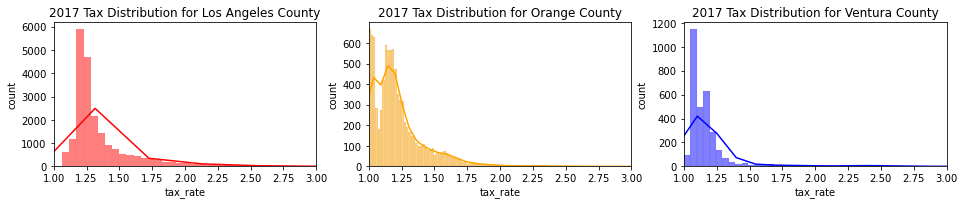

In [59]:
plt.figure(figsize=(16, 9))
plt.subplot(331)
sns.histplot(la_county, x= 'tax_rate', bins=1500, color = 'Red', kde=True)
plt.xlim(1, 3)
plt.ylabel('count')
plt.title('2017 Tax Distribution for Los Angeles County')
plt.subplot(332)
sns.histplot(orange_county, x='tax_rate', bins=600, color = 'Orange', kde=True)
plt.xlim(1, 3)
plt.ylabel('count')
plt.title('2017 Tax Distribution for Orange County')
plt.subplot(333)
sns.histplot(ventura_county, x='tax_rate', bins=600, color = 'Blue', kde=True)
plt.xlim(1, 3)
plt.ylabel('count')
plt.title('2017 Tax Distribution for Ventura County')

plt.savefig('taxrates.png')


In [60]:
#name of county per fips code 
counties = pd.DataFrame({'fips': [6037, 6059, 6111], 
                         'County':['Los Angeles', 'Orange', 'Ventura']})
counties

,fips,County
0,6037,Los Angeles
1,6059,Orange
2,6111,Ventura


In [61]:
grouped_median = zillow_df.groupby(zillow_df.fips).median()
grouped_mean = zillow_df.groupby(zillow_df.fips).mean()

print("median", grouped_median)
print(" ")
print("mean", round (grouped_mean, 2))

median       tax_rate
fips          
6037  1.256551
6059  1.164603
6111  1.128466
 
mean       tax_rate
fips          
6037      1.39
6059      1.21
6111      1.19
